In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [3]:
tf.__version__

'0.9.0'

In [4]:
data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb.mat')

In [5]:
m1 = np.transpose(data['D'][0,0]['M1'], [1, 0, 2, 3])
emg = np.transpose(data['D'][0,0]['EMG'], [1, 0, 2, 3])

m1 = np.reshape(m1, m1.shape[:2]+(4,)) # order = 'C' or 'F'
emg = np.reshape(emg, emg.shape[:2]+(4,)) # order = 'C' or 'F'

print 'M1 shape '+str(m1.shape)
print 'EMG shape '+str(emg.shape)

M1 shape (5092, 113, 4)
EMG shape (5092, 36, 4)


### plot of EMG

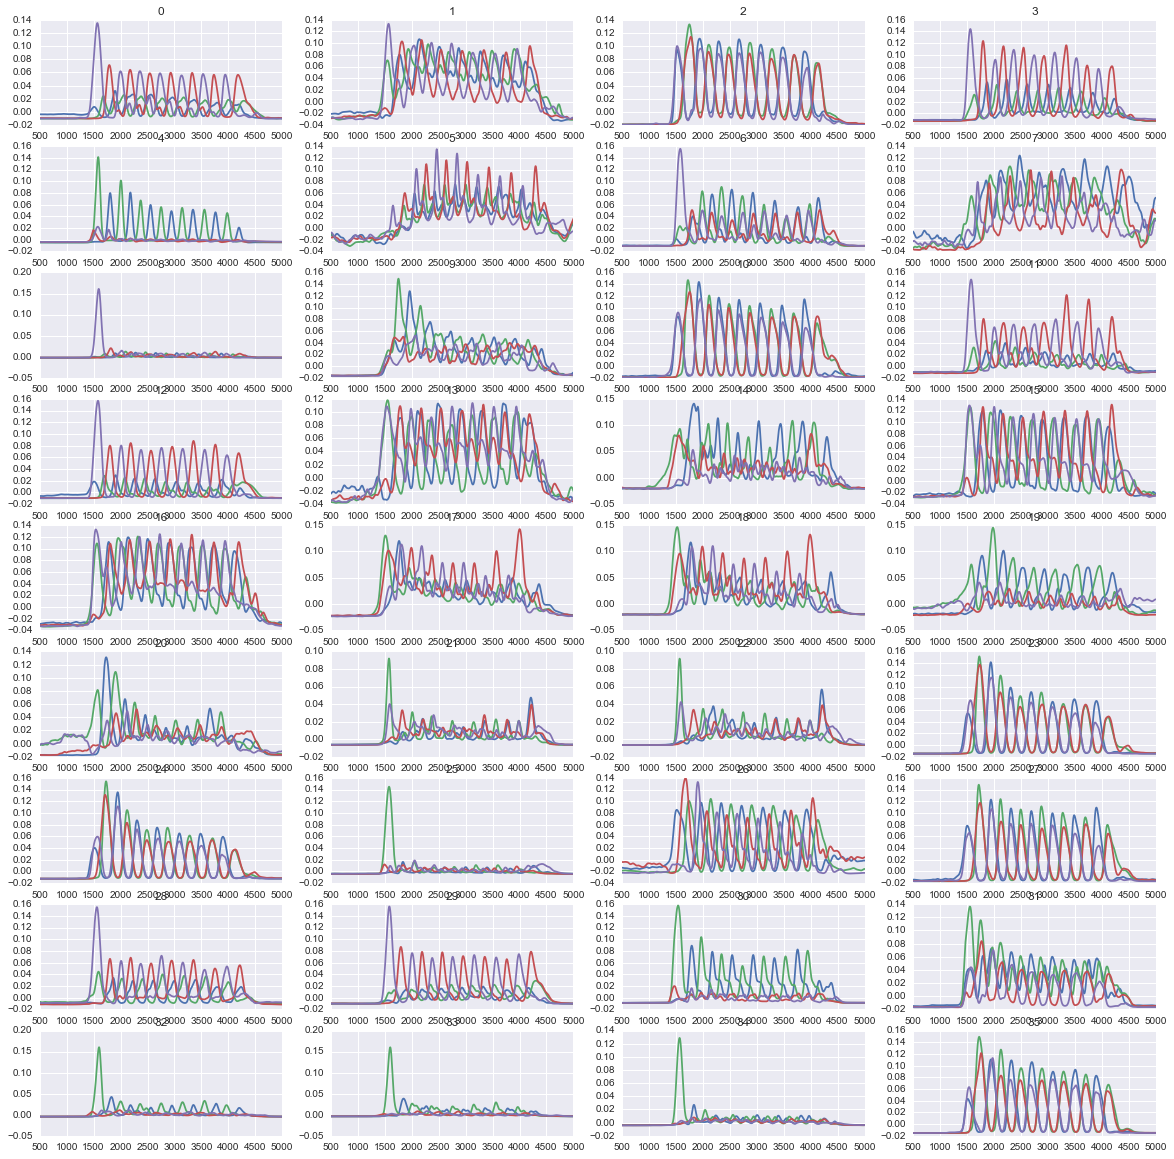

In [6]:
rows = 9
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        muscle = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(emg[:,muscle,:])
        ax[i,j].set_xlim((500,5000))
        ax[i,j].set_title(str(muscle))
plt.show()

In [7]:
times = np.arange(2000,4000, 10)
m1_ = m1[times]
emg_ = 10*emg[times]

In [8]:
pca_emg = sk.decomposition.PCA(n_components=5)
pca_m1 = sk.decomposition.PCA(n_components=5)

pca_emg.fit(np.concatenate([emg_[:,:,i] for i in range(4)]))
pca_m1.fit(np.concatenate([m1_[:,:,i] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

In [9]:
def make_pairgrid(d):
    ''' in: (d1,d2,d3,d4) '''
    df = pd.DataFrame(np.concatenate(d))
    cond_labels = d[0].shape[0]*['fw1'] + d[1].shape[0]*['fw2'] + d[2].shape[0]*['bw1'] + d[3].shape[0]*['bw2']
    df['condition'] = cond_labels
    g = sns.PairGrid(df, hue='condition', diag_sharey=True)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.plot)
    dmax = np.max(np.concatenate(d))
#     for i in range(g.axes.shape[0]):
#         for j in range(g.axes.shape[1]):
#             if i != j:
#                 g.axes[i,j].set_xlim(-dmax,dmax)
#                 g.axes[i,j].set_ylim(-dmax,dmax)
    
    g.add_legend()

### PC plots for EMG

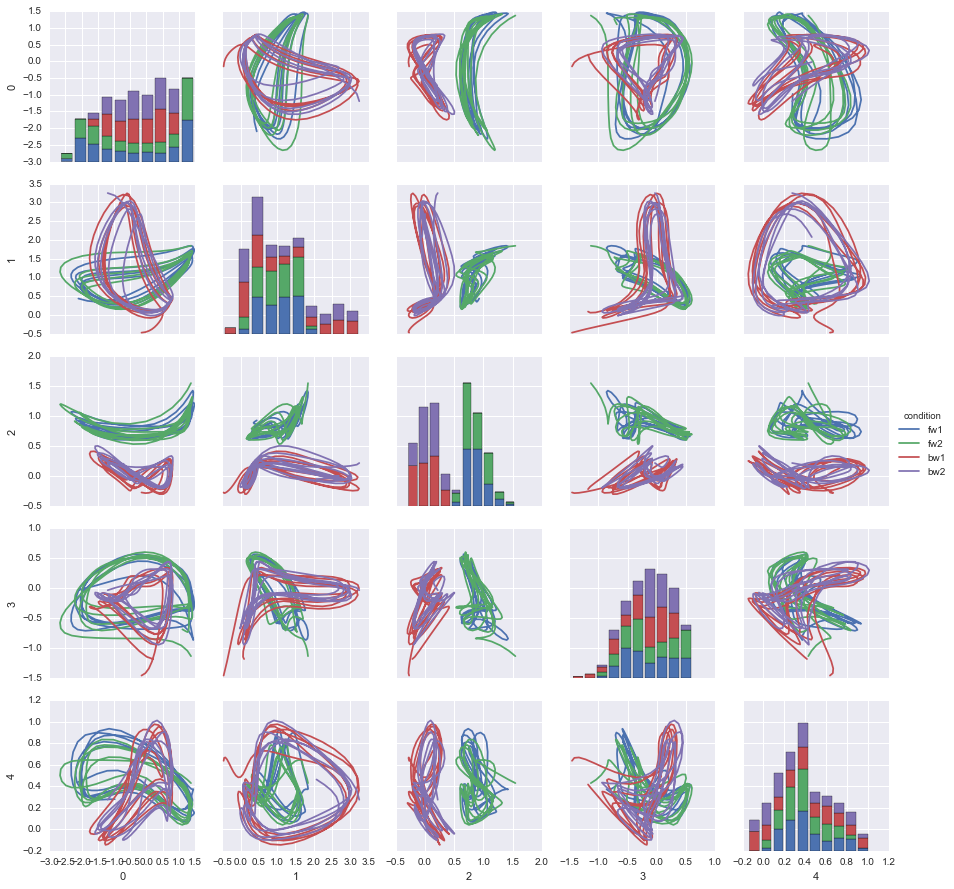

In [10]:
make_pairgrid([np.dot(emg_[:,:,i], pca_emg.components_.T) for i in range(4)])

### PC plots for M1

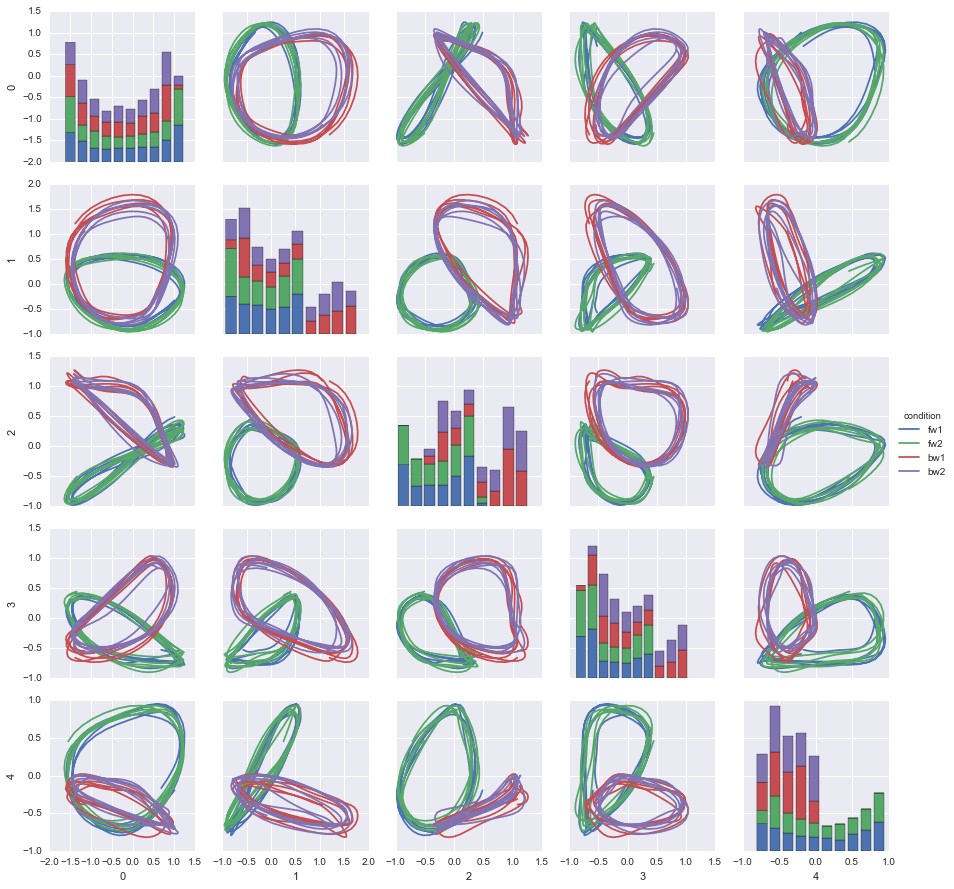

In [11]:
make_pairgrid([np.dot(m1_[:,:,i], pca_m1.components_.T) for i in range(4)])

### set up the data for tensorflow

In [12]:
# Some batch-related functions
def hankelize(a, time_steps_):
    """
    Convert size (T,n) matrix to size (num_steps, T-num_steps+1 , n) tensor.
    Different batches can now be selected by a[:,batch_inds,:].
    """
    dims = a.shape
    T_new_ = dims[0] - time_steps_ + 1
    b = np.zeros((T_new_, time_steps_) + dims[1:])
    for i in range(T_new_):
        b[i,:,:] = a[i:i+time_steps_, :]
    inds = range(b.ndim)
    inds[0], inds[1] = inds[1], inds[0]
    b = np.transpose(b, inds) # |
    return b

def get_rand_batch(data_, batch_size_):
    '''az
    args:
    return:
    '''
    inds = np.random.choice(data_[0].shape[1], batch_size_)
    for i in range(len(data_)):
        data_[i] = data_[i][:,inds,:]
    return inds, data_

In [13]:
# Time and batch parameters
time_steps = 10
batch_size = 10
T = emg.shape[0]
T_new = T - time_steps + 1

In [14]:
y_data_h = hankelize(emg_, time_steps)
print y_data_h.shape

(10, 191, 36, 4)


In [15]:
# even partition
y_data_e = y_data_h[:, :y_data_h.shape[1]:time_steps, :]
print y_data_e.shape

(10, 20, 36, 4)


In [16]:
y_data = np.concatenate([y_data_e[:,:,:,i] for i in range(4)], axis=1)
print y_data.shape

(10, 80, 36)


In [17]:
u_data = np.zeros(y_data.shape[:2]+(100,))

In [18]:
print emg_.size
print y_data.size

28800
28800


### tensorflow

In [19]:
tf.reset_default_graph()

m = u_data.shape[-1]
n = u_data.shape[-1]
p = y_data.shape[-1]
c = 4
total_batches = y_data.shape[1]

x0 = tf.Variable(tf.random_normal([total_batches,n], stddev=0.005), name='x0')

C = tf.Variable(tf.random_normal([n,p], stddev=0.5), name='C')
d = tf.Variable(tf.constant(0.1, shape=[1,p]), name='d')

U = tf.placeholder(tf.float32, [time_steps, None, n], name='U')
Y = tf.placeholder(tf.float32, [time_steps, None, p], name='Y')
Inds = tf.placeholder(tf.int32, [None,], name='batch_inds')

cell = tf.nn.rnn_cell.BasicRNNCell(n)
cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
output, _ = tf.nn.dynamic_rnn(cell, U, initial_state=tf.gather(x0, Inds), dtype=tf.float32, time_major=True)

Y_hat = tf.unpack(output)
Y_hat = [tf.matmul(Y_hat[i], C) + d for i in range(time_steps)]
Y_hat = tf.pack(Y_hat)

output_diff = tf.gather(output, range(1,time_steps))-tf.gather(output, range(0,time_steps-1))

Y_fetch = tf.identity(Y)

#Get A matrix
with tf.variable_scope('RNN/BasicRNNCell/Linear', reuse=True):
    A = tf.get_variable('Matrix')

In [20]:
beta1 = 0.1
beta2 = 0.01
gamma = 0.00001
cost = tf.reduce_mean((Y_hat - Y)**2)
+beta1*tf.nn.l2_loss(A)
+beta2*tf.nn.l2_loss(C) 
+gamma*tf.nn.l2_loss(output_diff) 
        
train_op = tf.train.AdamOptimizer(learning_rate=0.003) # add gradient_noise ? 
opt_op = train_op.minimize(cost)

In [21]:
tf.scalar_summary('loss', cost)
merged_summary_op = tf.merge_all_summaries()

In [22]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# tensorboard
summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)

for i in range(10000):
    inds_batch, [y_batch, u_batch] = get_rand_batch([y_data, u_data], batch_size)
    feed_dict = {Y: y_batch, U: u_batch, Inds: inds_batch}
    _, loss_val, summary_str = sess.run([opt_op, cost, merged_summary_op], feed_dict=feed_dict)
    summary_writer.add_summary(summary_str, i)
    
    if i % 500 == 0:
        print 'iter:', '%04d' % (i), \
              'Loss:', '{:.6f}'.format(loss_val)
print 'Finished'

iter: 0000 Loss: 0.115816
iter: 0500 Loss: 0.016690
iter: 1000 Loss: 0.008941
iter: 1500 Loss: 0.008065
iter: 2000 Loss: 0.007080
iter: 2500 Loss: 0.007773
iter: 3000 Loss: 0.006647
iter: 3500 Loss: 0.006994
iter: 4000 Loss: 0.007804
iter: 4500 Loss: 0.007821
iter: 5000 Loss: 0.006063
iter: 5500 Loss: 0.006704
iter: 6000 Loss: 0.005682
iter: 6500 Loss: 0.007064
iter: 7000 Loss: 0.006921
iter: 7500 Loss: 0.007425
iter: 8000 Loss: 0.006672
iter: 8500 Loss: 0.006132
iter: 9000 Loss: 0.006660
iter: 9500 Loss: 0.006451
Finished


In [23]:
feed_dict={Y: y_data, U: np.zeros((time_steps,u_data.shape[1],u_data.shape[-1])), Inds: np.arange(u_data.shape[1])}
y_tf, x_tf = sess.run([Y_hat, output], feed_dict=feed_dict)

In [24]:
def dehankelize(data_):
    data_ = np.concatenate([data_[:,i,:] for i in range(data_.shape[1])])
    data_ = np.reshape(data_, (data_.shape[0]/4, 4, data_.shape[1]), order='F')
    data_ = np.transpose(data_, (0,2,1))
    return data_

In [25]:
y_tf_ = dehankelize(y_tf)
x_tf_ = dehankelize(x_tf)

### plot EMG + fits

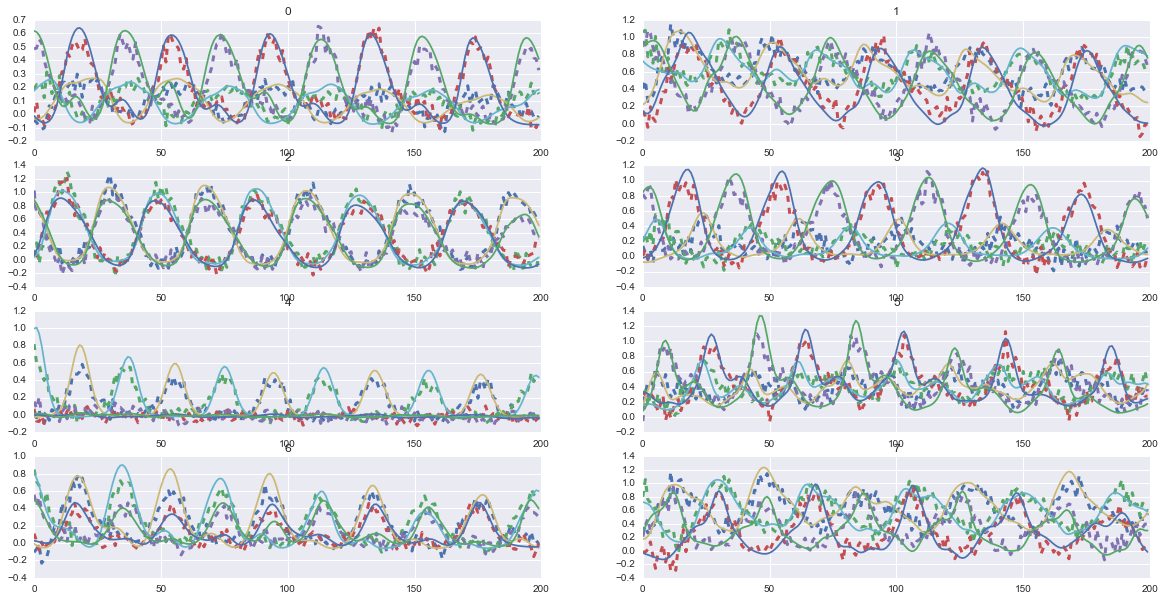

In [26]:
rows = 4
cols = 2
f, ax = plt.subplots(rows,cols, figsize=(20,10))

for i in range(rows):
    for j in range(cols):
        muscle = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(y_tf_[:,muscle,:],'--',linewidth=3)
        ax[i,j].plot(emg_[:,muscle,:])
        ax[i,j].set_title(str(muscle))
plt.show()

### PC plots

In [27]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf_[:,:,i] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf_[:,:,i] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

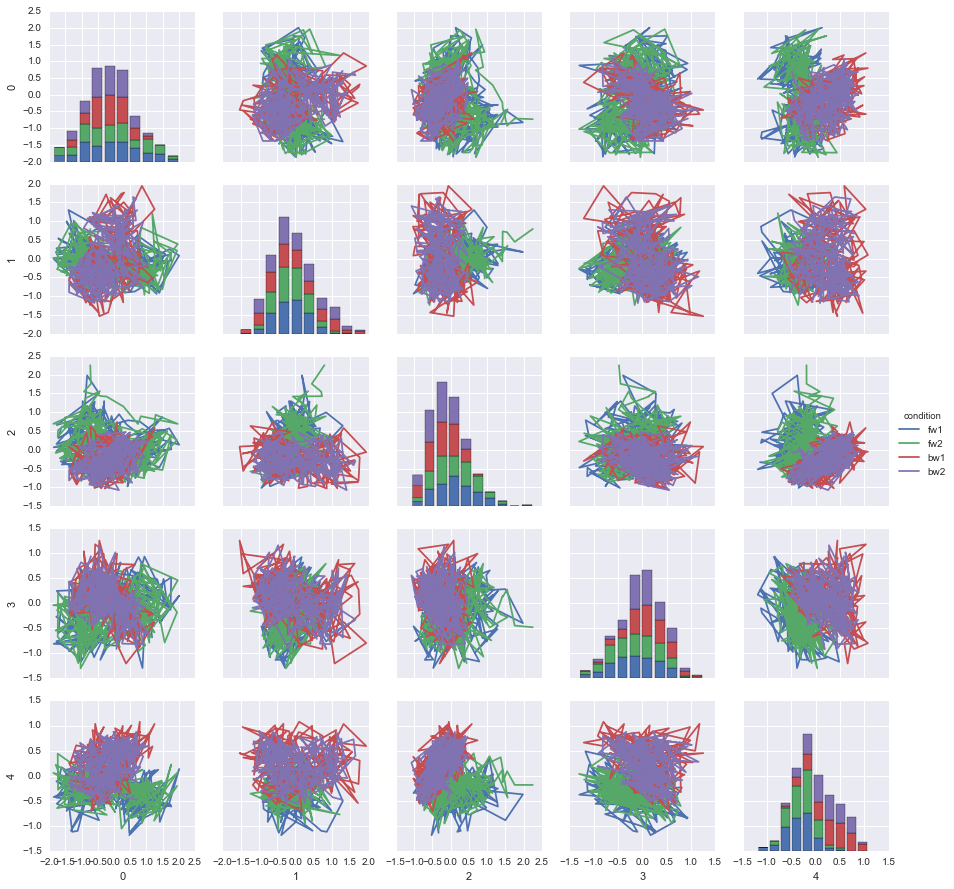

In [28]:
# plot PCs for the RNN state variable
make_pairgrid([np.dot(x_tf_[:,:,i], pca_x.components_.T) for i in range(4)])